In [54]:
import numpy as np
import pyomo.environ as pyo
from pyomo.environ import ConcreteModel, Var, ConstraintList, Objective, SolverFactory, value, RangeSet

import torch

import jax
import jax.numpy as jnp
from jax import random, jit
from jax.random import PRNGKey

# -------------- helper libraries -------------- #
import sys
import os
import time
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import importlib

path_ = os.path.abspath(os.path.join('..', '00_utils'))
if path_ not in sys.path:
    sys.path.append(path_)
    
path_ = os.path.abspath(os.path.join('..', '00_models'))
if path_ not in sys.path:
    sys.path.append(path_)

from data_generation import generate_ode_data

import nn_pytorch

In [70]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 200
noise_level = 0.2
ode_type, params = "harmonic_oscillator", {"omega_squared": 2}
start_time, end_time = 0, 10
spacing_type = "equally_spaced"
initial_state = np.array([0.0, 1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t_ho, y_ho, y_noisy_ho, true_derivatives_ho = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy_ho = np.array(jnp.squeeze(y_noisy_ho))
t_ho = np.array(jnp.squeeze(t_ho))

#---------------------------------------------------TEST DATA--------------------------------------------#
t_test_ho, y_test_ho, _, _ = generate_ode_data(N*2, noise_level, ode_type, params, start_time, end_time*2, "uniform", initial_state)

In [101]:
importlib.reload(nn_pytorch)
NeuralODE = nn_pytorch.NeuralODE

layer_widths = [2, 40, 2]
learning_rate = 1e-3

y_pred_results = {}

t = torch.tensor(np.array(t_ho), dtype=torch.float32)
y_noisy = torch.tensor(np.array(y_noisy_ho), dtype=torch.float32)
y0 = torch.tensor(initial_state, dtype=torch.float32)

ode_model = NeuralODE(layer_widths, learning_rate)

for k in [int(len(t)*0.1), len(t)]:
    ode_model.train_model(t[:k], y_noisy[:k], y0, num_epochs = 200)

# generate predictions
y_pred = ode_model.predict(t, y0)
y0_test = torch.tensor(np.array(y_test_ho[0]), dtype=torch.float32)
t_test_ho = torch.tensor(np.array(t_test_ho), dtype=torch.float32)
y_pred_test = ode_model.predict(t_test_ho, y0_test)

Epoch 0, Loss: 0.37653136253356934
Epoch 100, Loss: 0.022816775366663933
Epoch 0, Loss: 2.433377265930176
Epoch 100, Loss: 0.32517489790916443


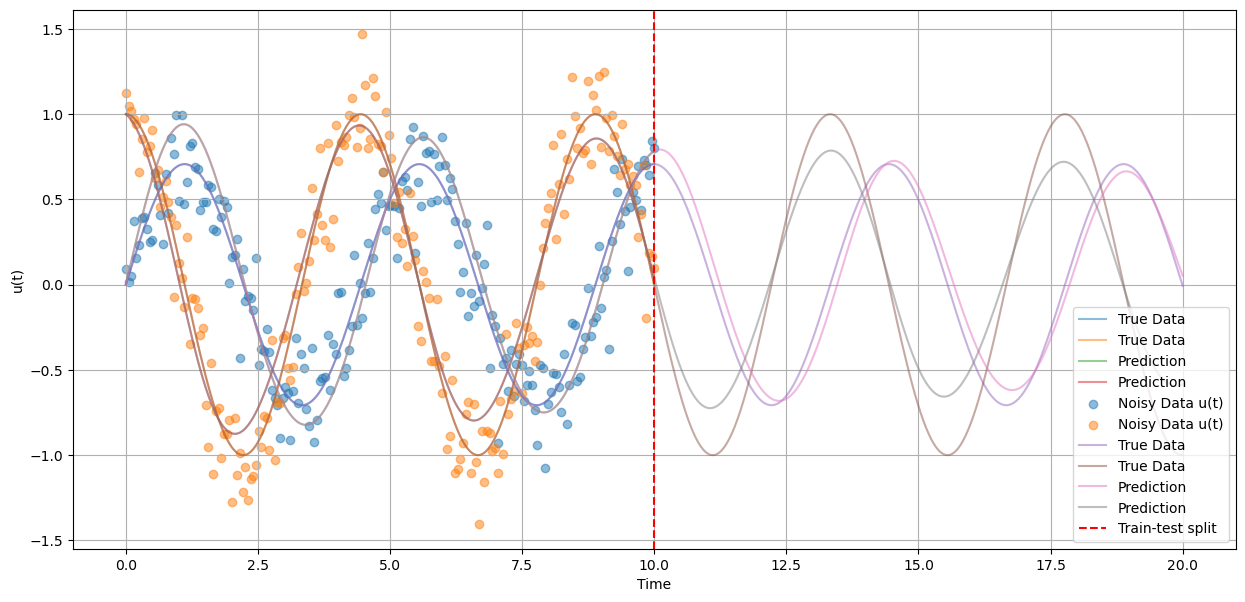

In [103]:
plt.figure(figsize=(15, 7))
plt.plot(t_ho, y_ho, label='True Data', alpha = 0.5)
plt.plot(t_ho, y_pred, label='Prediction', alpha = 0.5)
plt.scatter(t_ho, y_noisy[:,0], label='Noisy Data u(t)', alpha = 0.5)
plt.scatter(t_ho, y_noisy[:,1], label='Noisy Data u(t)', alpha = 0.5)

plt.plot(t_test_ho, y_test_ho, label='True Data', alpha = 0.5)
plt.plot(t_test_ho, y_pred_test, label='Prediction', alpha = 0.5)
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.axvline(x=10, color='r', linestyle='--', label='Train-test split')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

## Van Der Pol Oscillator

In [94]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 200
noise_level = 0.1
ode_type, params = "van_der_pol", {"mu": 1, "omega": 1}
start_time, end_time = 0, 15
spacing_type = "equally_spaced" # "equally_spaced" or "chebyshev"
initial_state = np.array([0.0, 1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t_vdp, y_vdp, y_noisy_vdp, true_derivatives_vdp = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

y_noisy_vdp = np.array(np.squeeze(y_noisy_vdp))
t_vdp = np.array(np.squeeze(t_vdp))

#---------------------------------------------------TEST DATA--------------------------------------------#
t_test_vdp, y_test_vdp, _, _ = generate_ode_data(N*2, noise_level, ode_type, params, start_time, end_time*2, "uniform", initial_state)

In [111]:
importlib.reload(nn_pytorch)
NeuralODE = nn_pytorch.NeuralODE

layer_widths = [2, 30, 30, 2]
learning_rate = 1e-3

y_pred_results = {}

t = torch.tensor(np.array(t_vdp), dtype=torch.float32)
y_noisy = torch.tensor(np.array(y_noisy_vdp), dtype=torch.float32)
y0 = torch.tensor(initial_state, dtype=torch.float32)

ode_model = NeuralODE(layer_widths, learning_rate)

for k in [int(len(t)*0.1), len(t)]:
    ode_model.train_model(t[:k], y_noisy[:k], y0, num_epochs = 1000)

# generate predictions
y_pred = ode_model.predict(t, y0)
y0_test = torch.tensor(np.array(y_test_vdp[0]), dtype=torch.float32)
t_test_vdp = torch.tensor(np.array(t_test_vdp), dtype=torch.float32)
y_pred_test = ode_model.predict(t_test_vdp, y0_test)

Epoch 0, Loss: 1.0758030414581299
Epoch 100, Loss: 0.13214372098445892
Epoch 200, Loss: 0.008492044173181057
Epoch 300, Loss: 0.0070786261931061745
Epoch 400, Loss: 0.006509496830403805
Epoch 500, Loss: 0.006206902675330639
Epoch 600, Loss: 0.006007820833474398
Epoch 700, Loss: 0.0058449674397706985
Epoch 800, Loss: 0.0056953937746584415
Epoch 900, Loss: 0.005552401300519705
Epoch 0, Loss: 274.74639892578125
Epoch 100, Loss: 0.8416284322738647
Epoch 200, Loss: 0.6713665723800659
Epoch 300, Loss: 0.5773861408233643
Epoch 400, Loss: 0.5022151470184326
Epoch 500, Loss: 0.49501433968544006
Epoch 600, Loss: 0.47727105021476746
Epoch 700, Loss: 0.3938230276107788
Epoch 800, Loss: 0.35549286007881165
Epoch 900, Loss: 0.3680188059806824


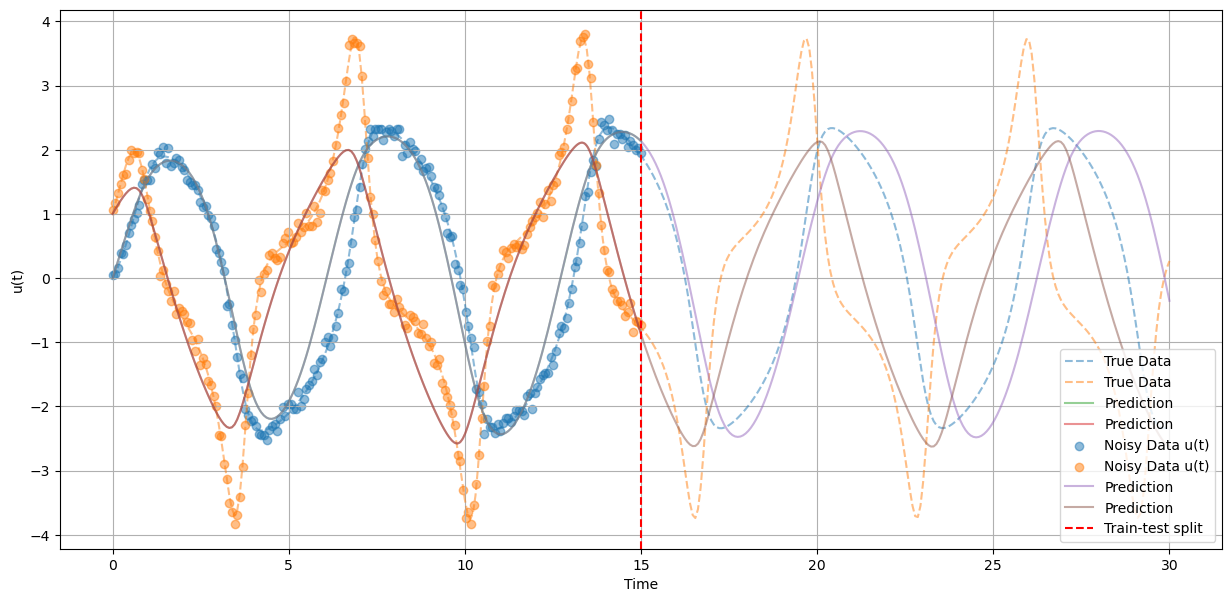

In [114]:
plt.figure(figsize=(15, 7))
plt.plot(t_test_vdp, y_test_vdp, '--',label='True Data', alpha = 0.5)
plt.plot(t_vdp, y_pred, label='Prediction', alpha = 0.5)
plt.scatter(t_vdp, y_noisy[:,0], label='Noisy Data u(t)', alpha = 0.5)
plt.scatter(t_vdp, y_noisy[:,1], label='Noisy Data u(t)', alpha = 0.5)

plt.plot(t_test_vdp, y_pred_test, label='Prediction', alpha = 0.5)

plt.xlabel('Time')
plt.ylabel('u(t)')
plt.axvline(x=15, color='r', linestyle='--', label='Train-test split')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

----

### The next step is to pass extra arguments into the `odeint` function to learn to predict data with auxiliary information.
* To focus purely on the methodology, a simpler dataset is used (`harmonic_oscillator`).

In [130]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 200
noise_level = 0.2
ode_type, params = "harmonic_oscillator", {"omega_squared": 2}
start_time, end_time = 0, 10
spacing_type = "equally_spaced"
initial_state = np.array([0.0, 1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t_ho, y_ho, y_noisy_ho, true_derivatives_ho = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy_ho = np.array(jnp.squeeze(y_noisy_ho))
t_ho = np.array(jnp.squeeze(t_ho))

#---------------------------------------------------TEST DATA--------------------------------------------#
t_test_ho, y_test_ho, _, _ = generate_ode_data(N*2, noise_level, ode_type, params, start_time, end_time*2, "uniform", initial_state)

In [150]:
importlib.reload(nn_pytorch)
NeuralODE = nn_pytorch.NeuralODE

layer_widths = [3, 40, 2]
learning_rate = 1e-3

y_pred_results = {}

t = torch.tensor(np.array(t_ho), dtype=torch.float32)
y_noisy = torch.tensor(np.array(y_noisy_ho), dtype=torch.float32)
y0 = torch.tensor(initial_state, dtype=torch.float32)

ode_model = NeuralODE(layer_widths, learning_rate, time_invariant=False)

for k in [int(len(t)*0.1), len(t)]:
    ode_model.train_model(t[:k], y_noisy[:k], y0, num_epochs = 500)

# generate predictions
y_pred = ode_model.predict(t, y0)
y0_test = torch.tensor(np.array(y_test_ho[0]), dtype=torch.float32)
t_test_ho = torch.tensor(np.array(t_test_ho), dtype=torch.float32)
y_pred_test = ode_model.predict(t_test_ho, y0_test)

Epoch 0, Loss: 0.44867968559265137
Epoch 100, Loss: 0.02138972096145153
Epoch 200, Loss: 0.020846202969551086
Epoch 300, Loss: 0.020381806418299675
Epoch 400, Loss: 0.0200105682015419
Epoch 0, Loss: 17.285459518432617
Epoch 100, Loss: 0.31840598583221436
Epoch 200, Loss: 0.23840509355068207
Epoch 300, Loss: 0.04142053425312042
Epoch 400, Loss: 0.03653757646679878


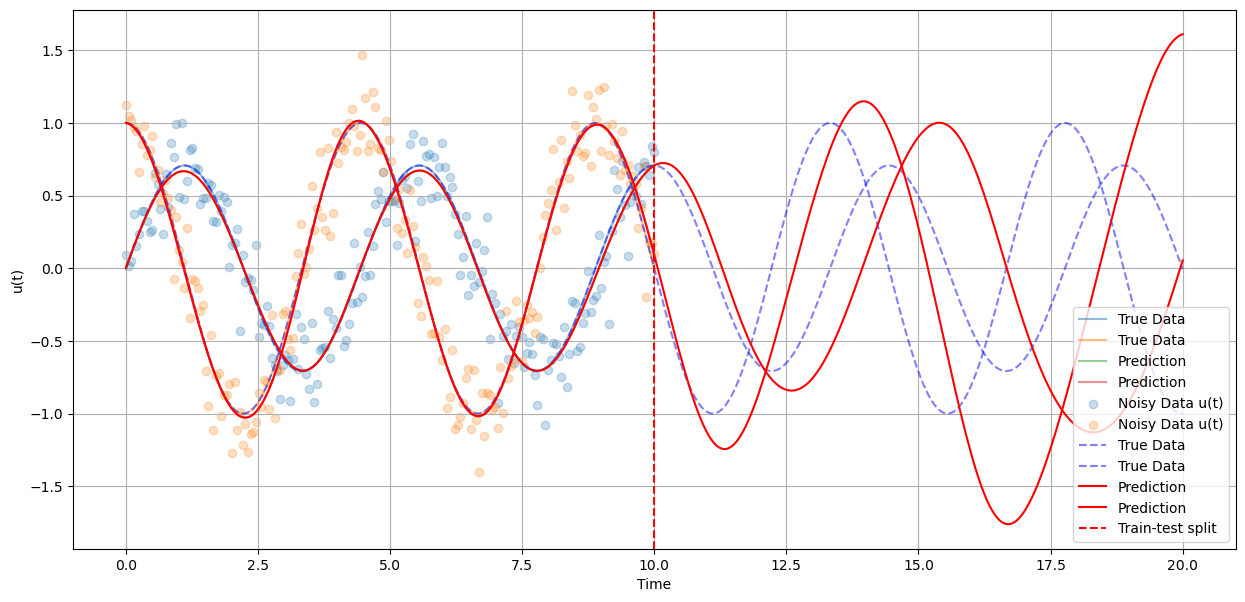

In [151]:
plt.figure(figsize=(15, 7))
plt.plot(t_ho, y_ho, label='True Data', alpha = 0.5)
plt.plot(t_ho, y_pred, label='Prediction', alpha = 0.5)
plt.scatter(t_ho, y_noisy[:,0], label='Noisy Data u(t)', alpha = 0.25)
plt.scatter(t_ho, y_noisy[:,1], label='Noisy Data u(t)', alpha = 0.25)

plt.plot(t_test_ho, y_test_ho, 'b--', label='True Data', alpha = 0.5)
plt.plot(t_test_ho, y_pred_test, 'r',label='Prediction', alpha = 1)
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.axvline(x=10, color='r', linestyle='--', label='Train-test split')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

In [255]:
L, R = 0, 400

ys = torch.tensor(np.atleast_2d(y_noisy_ho[L:R, 0]).T, dtype=torch.float32)
ts = torch.tensor(np.array(t_ho)[L:R], dtype=torch.float32)
Xs = np.atleast_2d(y_noisy_ho[L:R, 1]).T # extra inputs

In [257]:
Xs.shape

(200, 1)

In [251]:
layer_widths = [2, 40, 1]
learning_rate = 1e-3

y_pred_results = {}

y0 = torch.tensor(np.array([0.0]), dtype=torch.float32)

ode_model = NeuralODE(layer_widths, learning_rate, time_invariant = True)

for k in [int(len(t)*0.1), len(t)]:
    ode_model.train_model(ts[:k], ys[:k], y0, num_epochs = 200, extra_inputs = Xs[:k])

Epoch 0, Loss: 0.29812589287757874
Epoch 100, Loss: 0.023486128076910973
Epoch 0, Loss: 7.353426933288574
Epoch 100, Loss: 0.04218965396285057


In [252]:
# generate predictions
y_pred = ode_model.predict(ts, y0)
"""y0_test = torch.tensor(np.array(y_test_ho[0]), dtype=torch.float32)
t_test_ho = torch.tensor(np.array(t_test_ho), dtype=torch.float32)
y_pred_test = ode_model.predict(t_test_ho, y0_test)""";

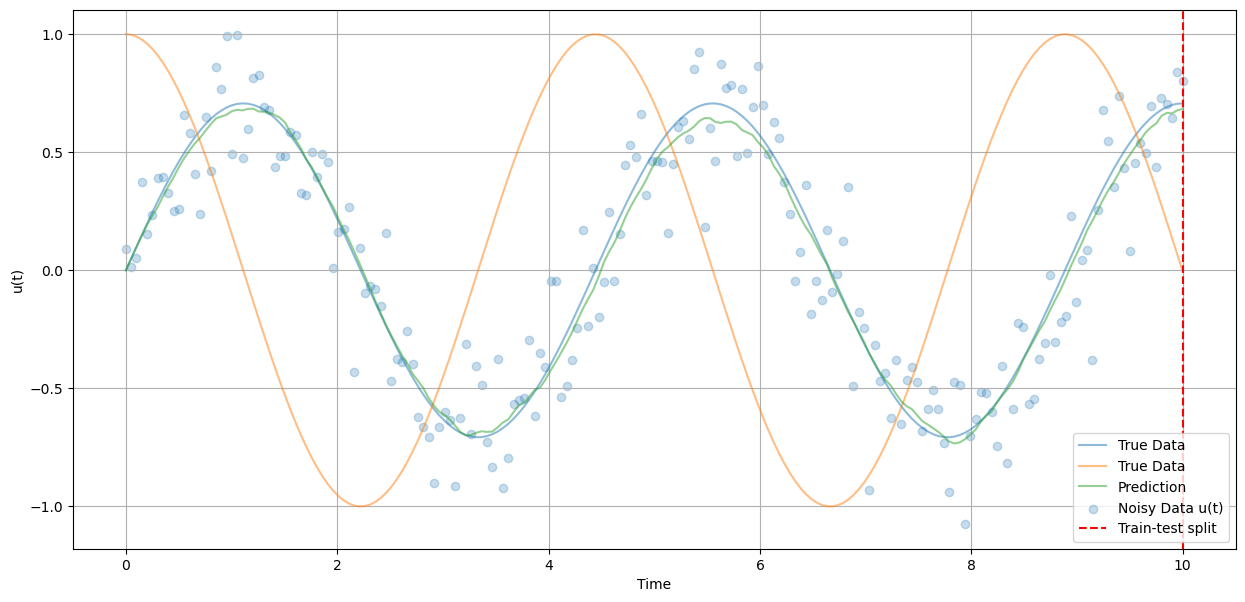

In [253]:
plt.figure(figsize=(15, 7))
plt.plot(t_ho, y_ho, label='True Data', alpha = 0.5)
plt.plot(t_ho, y_pred, label='Prediction', alpha = 0.5)
plt.scatter(t_ho, y_noisy[:,0], label='Noisy Data u(t)', alpha = 0.25)

#plt.plot(t_test_ho, y_test_ho, 'b--', label='True Data', alpha = 0.5)
#plt.plot(t_test_ho, y_pred_test, 'r',label='Prediction', alpha = 1)
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.axvline(x=10, color='r', linestyle='--', label='Train-test split')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()